In [1]:
import torch
from transformers import AutoModel
from transformers import AutoImageProcessor
import numpy as np
from PIL import Image
from mammodata import MammogramPreprocessor
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

# Download the model
repo = "microsoft/rad-dino"
model = AutoModel.from_pretrained(repo)
# The processor takes a PIL image, performs resizing, center-cropping, and
# intensity normalization using stats from MIMIC-CXR, and returns a
# dictionary with a PyTorch tensor ready for the encoder
processor = AutoImageProcessor.from_pretrained(repo)
processor.to_dict()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


{'_processor_class': None,
 'image_processor_type': 'BitImageProcessor',
 'do_resize': True,
 'size': {'shortest_edge': 518},
 'resample': 3,
 'do_center_crop': True,
 'crop_size': {'height': 518, 'width': 518},
 'do_rescale': True,
 'rescale_factor': 0.00392156862745098,
 'do_normalize': True,
 'image_mean': [0.5307, 0.5307, 0.5307],
 'image_std': [0.2583, 0.2583, 0.2583],
 'do_convert_rgb': True}

In [3]:
mammo_preprocessor = MammogramPreprocessor((518, 518))

image size: (2048, 2048)


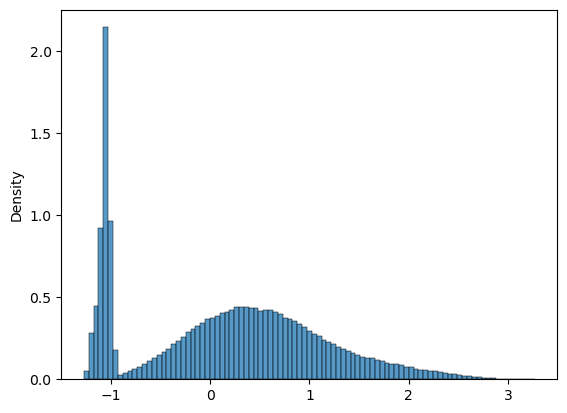

image size after processing: (1, 518, 518)
image size after processing: torch.Size([1, 1, 518, 518])
image size after processing: torch.Size([1, 3, 518, 518])


In [4]:
# Download and preprocess a chest X-ray
original_image = Image.open("./data/jpegs/0039380963_l_cc.jpeg")
image = np.array(original_image.copy().convert("L"))
print("image size:", image.shape)   # (width, height)
image = mammo_preprocessor(image)
processed_image = Image.fromarray((image.copy()*255).astype(np.uint8).squeeze())

image = (image - .281) / .218


sns.histplot(image.flatten(), stat="density")
plt.show()

print("image size after processing:", image.shape)   # (1, width, height)
image = torch.from_numpy(image).unsqueeze(0)  # add batch dimension
print("image size after processing:", image.shape)   # (1, 1, width, height)
image = image.repeat(1, 3, 1, 1)
print("image size after processing:", image.shape)   # (1, 3, width, height)

In [5]:

# Encode the image!
with torch.inference_mode():
    outputs = model(pixel_values=image)
# Look at the CLS embeddings
cls_embeddings = outputs.pooler_output
cls_embeddings.shape  # (batch_size, num_channels)


torch.Size([1, 768])

In [6]:
def reshape_patch_embeddings(flat_tokens: torch.Tensor) -> torch.Tensor:
    """Reshape flat list of patch tokens into a nice grid."""
    from einops import rearrange
    image_size = processor.crop_size["height"]
    patch_size = model.config.patch_size
    embeddings_size = image_size // patch_size
    patches_grid = rearrange(flat_tokens, "b (h w) c -> b c h w", h=embeddings_size)
    return patches_grid
flat_patch_embeddings = outputs.last_hidden_state[:, 1:]  # first token is CLS
reshaped_patch_embeddings = reshape_patch_embeddings(flat_patch_embeddings)
reshaped_patch_embeddings.shape  # (batch_size, num_channels, height, width)


torch.Size([1, 768, 37, 37])

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np


def plot_embeddings_overlay(
    embeddings: torch.Tensor, original_image: Image.Image
) -> None:
    """Plot the patch embeddings overlaid on the original image with an interactive channel selector."""
    bs, c, h, w = embeddings.shape

    # Convert the original image to numpy array and ensure grayscale
    img_array = np.array(original_image.convert("L"))

    # Create a figure that persists between interactions
    plt.ioff()  # Turn off interactive mode to avoid duplicate displays
    fig, ax = plt.subplots(figsize=(8, 8))

    def update_plot(channel, alpha=0.7):
        ax.clear()

        # Display the original image
        ax.imshow(img_array, cmap="gray", alpha=1.0)

        # Overlay the feature map with transparency
        feature_map = embeddings[0, channel].cpu().numpy()

        # Resize feature map to match image dimensions using nearest neighbor interpolation
        # for visualization purposes
        im = ax.imshow(
            feature_map,
            cmap="plasma",
            alpha=alpha,
            interpolation="bicubic",
            extent=(0, img_array.shape[1], img_array.shape[0], 0),
        )

        ax.set_title(f"Channel {channel} Overlay")
        ax.axis("off")

        # Add colorbar
        if not hasattr(update_plot, "cbar"):
            update_plot.cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            update_plot.cbar.update_normal(im)

        fig.canvas.draw_idle()
        return fig

    # Create interactive widgets
    channel_slider = widgets.IntSlider(
        min=0,
        max=c - 1,
        step=1,
        value=0,
        description="Channel:",
        style={"description_width": "initial"},
        layout={"width": "500px"},
    )

    alpha_slider = widgets.FloatSlider(
        min=0.1,
        max=1.0,
        step=0.05,
        value=0.7,
        description="Opacity:",
        style={"description_width": "initial"},
        layout={"width": "500px"},
    )

    # Create interactive plot
    interact(update_plot, channel=channel_slider, alpha=alpha_slider)
    plt.tight_layout()


# Use the enhanced interactive function with original image
plot_embeddings_overlay(reshaped_patch_embeddings, processed_image)

interactive(children=(IntSlider(value=0, description='Channel:', layout=Layout(width='500px'), max=767, style=…